In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import pyplot as plt
from os import path
from quenching import calc_quenched_flour, fit_quenching_linear_unitless, mark_non_quenchers
from quenching import well_mean_with_error_propagation

In [2]:
# Load data from in-vitro RTDP plate reader experiments. 
long_df_pre = pd.read_csv('../data/O2NS_supes/O2NS_long_df_pre.csv', index_col=0)
long_df_post = pd.read_csv('../data/O2NS_supes/O2NS_long_df_post.csv', index_col=0)
# Manually mixed prior to measurement here, so we will keep all the data.

# Infer the quenched fluorescence by comparing pre/post measurements
long_df_pre, long_df_post, blank_vals, pt_alone_fluors = calc_quenched_flour(
    long_df_pre, long_df_post, "pt_fluor", "O2NS")

# In this case data comes from a single date, so there is only one blank (mean+/-std) and reference value.
blank_val = blank_vals.iloc[0]
pt_alone_fluor = pt_alone_fluors.iloc[0]

long_df_pre.to_csv("../data/O2NS_supes/O2NS_long_df_pre_processed.csv")
long_df_post.to_csv("../data/O2NS_supes/O2NS_long_df_post_processed.csv")

print("blank", blank_val)
print("O2NS (PtTFPP) in buffer", pt_alone_fluor)
cv = pt_alone_fluor.std_dev/pt_alone_fluor.nominal_value
print("CV of O2NS (PtTFPP) in buffer {0:.2f}%".format(100*cv))

blank 56.9+/-3.1
O2NS (PtTFPP) in buffer (5.83+/-0.31)e+03
CV of O2NS (PtTFPP) in buffer 5.38%


In [3]:
# Peek at the data
mask = long_df_post.name == 'PA14 WT'
long_df_post[mask].head()

,time_s,well,pt_fluor,concentration,fold_dilution,media,name,replicate,plate,date,blanked_pt_fluor,expected_blanked_pt_fluor,estimated_true_pt_fluor,F0_F_ratio,F_F0_ratio,u_blanked_pt_fluor,u_expected_blanked_pt_fluor,u_estimated_true_pt_fluor,u_F0_F_ratio,u_F_F0_ratio
0,0.000,A1,6931,0.900901,1,MM noC,PA14 WT,1,1,1/11/22,6874.125,9192.722691,3511.850225,1.660221,0.602329,3.143079,313.580099,0.311476,0.089288,0.032394
1,140.070,A1,6673,0.900901,1,MM noC,PA14 WT,1,1,1/11/22,6616.125,9169.299268,3277.273649,1.779054,0.562096,3.143079,313.580099,0.311476,0.095679,0.030230
2,280.267,A1,6560,0.900901,1,MM noC,PA14 WT,1,1,1/11/22,6503.125,9152.182151,3181.390766,1.832673,0.545651,3.143079,313.580099,0.311476,0.098563,0.029346
3,420.328,A1,6447,0.900901,1,MM noC,PA14 WT,1,1,1/11/22,6390.125,9135.065034,3085.507883,1.889623,0.529206,3.143079,313.580099,0.311476,0.101626,0.028461
4,0.000,A2,6351,0.450450,2,MM noC,PA14 WT,1,1,1/11/22,6294.125,7894.524493,4230.048423,1.378341,0.725510,3.143079,313.580099,0.311476,0.074129,0.039019


In [4]:
means_pre_by_rep = well_mean_with_error_propagation(long_df_pre, "pt_fluor", pt_alone_fluor)
means_post_by_rep = well_mean_with_error_propagation(long_df_post, "pt_fluor", pt_alone_fluor)
means_pre_by_rep.to_csv("../data/O2NS_supes/mean_O2NS_fluor_pre.csv")
means_post_by_rep.to_csv("../data/O2NS_supes/mean_O2NS_fluor_post.csv")

In [5]:
# calculate the KSV values for RTDP + various molecules by fitting to the linear form of 
# the Stern-Volmer model of equilibrium quenching. We fit the averaged data so that each 
# well is counted only once during the fitting. 

# Molecules are called non-quenchers if quenching is only weakly correlated with their
# concentrations or, alternatively, if the degree of quenching is low enought to be 
# consistent with no quenching at all, i.e. if it cannot be distinguished from the 
# variance of the signal of sensor (O2NS here) in buffer.
name_order = sorted(
    set(long_df_post.name.unique()).difference('BLANK,O2NS'.split(',')))
print(name_order)
fitting_df = means_post_by_rep.reset_index()
quencher_fit_df = fit_quenching_linear_unitless(fitting_df, name_order)

min_KSV = cv*pt_alone_fluor.nominal_value
print("Minimum effect size (CV of O2NS): {0:.2g}".format(cv))
quencher_fit_df = mark_non_quenchers(quencher_fit_df, min_effect_size=cv)

# Save the fits
quencher_fit_df.to_csv("../data/O2NS_supes/fits.csv")
quencher_fit_df

['BG WT', 'BG dtox', 'EC WT', 'PA14 WT', 'PA14 dphz', 'PA14 dphz dside', 'PA14 dside']
Fitting BG WT
	F0/F ~ [BG WT] with R = 0.855
	Data for 6 concentrations
Fitting BG dtox
	F0/F ~ [BG dtox] with R = 0.806
	Data for 6 concentrations
Fitting EC WT
	F0/F ~ [EC WT] with R = 0.673
	Data for 6 concentrations
Fitting PA14 WT
	F0/F ~ [PA14 WT] with R = 0.951
	Data for 6 concentrations
Fitting PA14 dphz
	F0/F ~ [PA14 dphz] with R = 0.767
	Data for 6 concentrations
Fitting PA14 dphz dside
	F0/F ~ [PA14 dphz dside] with R = 0.938
	Data for 6 concentrations
Fitting PA14 dside
	F0/F ~ [PA14 dside] with R = 0.940
	Data for 6 concentrations
Minimum effect size (CV of O2NS): 0.054


,name,K_SV,K_SV err,R,N_concs,quencher
0,BG WT,0.430799,0.104763,0.855467,6,True
1,BG dtox,0.250078,0.076498,0.805580,6,True
2,EC WT,0.060382,0.057839,0.673150,6,False
3,PA14 WT,0.842958,0.098194,0.951446,6,True
4,PA14 dphz,0.497063,0.087957,0.767023,6,True
5,PA14 dphz dside,0.568596,0.089242,0.937639,6,True
6,PA14 dside,0.772398,0.114673,0.939583,6,True


All is now preprocessed, fit and exported. 
Everything below here is just exploring the data.

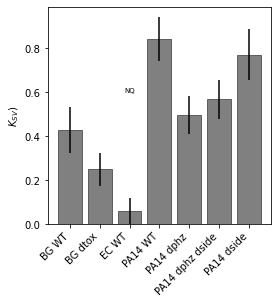

In [6]:
# Index fits by name for easier lookup
o2ns_fits = quencher_fit_df.set_index('name')

# Some of the better quenchers, e.g. toxoflavin, give a non-linear response curve as expected from theory. 
# However, the non-linear model has an additional degree of freedom, it gives much larger errors on the KSV value.
# As such it makes more sense to report value +/- error for the linear model and discuss the non-linearity in the SI.
xs = np.arange(o2ns_fits.index.size)
ys = o2ns_fits['K_SV']
yerr = o2ns_fits['K_SV err']

plt.figure(figsize=(4,4))
plt.bar(xs, ys, yerr=yerr, color='grey', edgecolor='k', lw=0.5, ecolor='k')

for i, (idx, row) in enumerate(o2ns_fits.iterrows()):
    if not row.quencher:
        plt.text(i, 0.6, 'NQ', ha='center', fontsize=7)
        
plt.ylabel('$K_{SV}$)')
plt.xticks(xs, o2ns_fits.index, rotation=45, ha='right')
plt.show()

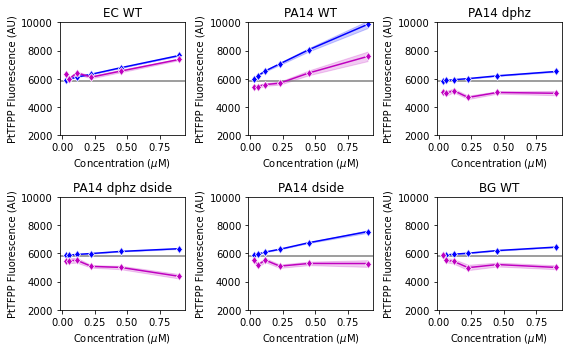

In [7]:
fig, axs = plt.subplots(figsize=(8,5), ncols=3, nrows=2)
flat_axs = axs.flatten()
name_order = [
    'EC WT', 'PA14 WT', 'PA14 dphz',
    'PA14 dphz dside', 'PA14 dside', 'BG WT', 'BG dtox']

for qname, my_ax in zip(name_order, flat_axs):
    plt.sca(my_ax)
    
    qdf_pre = long_df_pre[long_df_pre.name == qname]
    qdf_post = long_df_post[long_df_post.name == qname]
    
    plt.axhline(pt_alone_fluor.nominal_value, color='grey')
    sns.lineplot(data=qdf_post, x='concentration', y='expected_blanked_pt_fluor', 
                 color='b', marker='d', markersize=6)
    
    sns.lineplot(data=qdf_post, x='concentration', y='blanked_pt_fluor', 
                 color='m', marker='d', markersize=6)
    
    plt.title(qname)
    plt.ylim(2000, 10000)
    plt.xlabel('Concentration ($\mu$M)')
    plt.ylabel('PtTFPP Fluorescence (AU)')
    
plt.tight_layout()
plt.savefig('../figures/o2ns_vitro.png', facecolor='w', dpi=600)
plt.show()

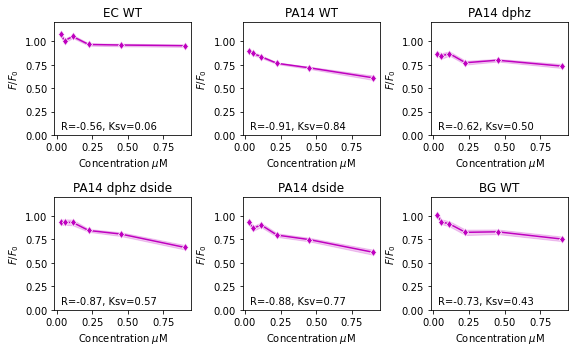

In [8]:
fig, axs = plt.subplots(figsize=(8,5), ncols=3, nrows=2)
flat_axs = axs.flatten()
name_order = [
    'EC WT', 'PA14 WT', 'PA14 dphz',
    'PA14 dphz dside', 'PA14 dside', 'BG WT', 'BG dtox']

for qname, my_ax in zip(name_order, flat_axs):
    plt.sca(my_ax)
    
    qdf_pre = long_df_pre[long_df_pre.name == qname]
    qdf_post = long_df_post[long_df_post.name == qname]
    
    sns.lineplot(data=qdf_post, x='concentration', y='F_F0_ratio', 
                 color='m', marker='d', markersize=6)
    
    corr = qdf_post.corr().loc['concentration', 'F_F0_ratio']
    slope = o2ns_fits.loc[qname]['K_SV']
    plt.text(0.05, 0.05, 'R={0:.2f}, Ksv={1:0.2f}'.format(corr, slope),
             transform=my_ax.transAxes)
    
    plt.title(qname)
    plt.ylim(0, 1.2)
    plt.xlabel('Concentration $\mu$M')
    plt.ylabel('$F / F_0$')
    
plt.tight_layout()

In [9]:
long_df_post[long_df_post.name == 'PA14 WT'].groupby('concentration').mean()

,time_s,pt_fluor,fold_dilution,replicate,plate,blanked_pt_fluor,expected_blanked_pt_fluor,estimated_true_pt_fluor,F0_F_ratio,F_F0_ratio,u_blanked_pt_fluor,u_expected_blanked_pt_fluor,u_estimated_true_pt_fluor,u_F0_F_ratio,u_F_F0_ratio
concentration,,,,,,,,,,,,,,,
0.028153,210.16625,5493.9375,32.0,1.5,1.0,5437.0625,6021.157376,5246.353041,1.113492,0.899820,3.143079,313.580099,0.311476,0.059885,0.048393
0.056306,210.16625,5507.6250,16.0,1.5,1.0,5450.7500,6210.008727,5071.189189,1.152111,0.869777,3.143079,313.580099,0.311476,0.061962,0.046778
0.112613,210.16625,5650.0625,8.0,1.5,1.0,5593.1875,6552.182151,4871.453266,1.198360,0.835520,3.143079,313.580099,0.311476,0.064449,0.044935
0.225225,210.16625,5743.6250,4.0,1.5,1.0,5686.7500,7059.389358,4457.808559,1.308787,0.764574,3.143079,313.580099,0.311476,0.070388,0.041120
0.450450,210.16625,6474.0000,2.0,1.5,1.0,6417.1250,8066.821791,4180.751126,1.396245,0.717055,3.143079,313.580099,0.311476,0.075092,0.038564
0.900901,210.16625,7640.5000,1.0,1.5,1.0,7583.6250,9856.292511,3557.780405,1.649813,0.610207,3.143079,313.580099,0.311476,0.088729,0.032818


In [10]:
groupby

NameError: name 'groupby' is not defined